# Homework 3
Note, homework report is at the very end of this notebook. 

In [22]:
from statistics import mode

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import xarray as xr
import xskillscore as xs
import matplotlib.colors as colors 
from scipy.optimize import curve_fit
from scipy.stats import gamma, kurtosis, linregress, norm, ranksums, skew
from scipy.stats import ttest_ind as ttest
from tabulate import tabulate

In [23]:
""" Load data """
precip = xr.open_dataset("precip.V1.0.mon.mean2020.nc")
precip = precip.sel(time=np.arange("1950-01", "2018-01", dtype="datetime64[M]"))

""" Unravel matlab dict object """
nino = scipy.io.loadmat("Nino_3-4.mat")
nino4 = nino["nino4"].T
nino3 = nino["nino3"].T
nino34 = nino["nino34"].T
nino34_anom = nino["anom34"].T
nino_years = nino["year"].T

# Table 1

In [24]:
# First thing first: Lets get some basic information about these data sets
def tabulate_statistics(data, title):
    # mean, median, standard deviation, skewness, and coefficient of kurtosis
    table = [
        ["Mean", np.nanmean(data)],
        ["Median", np.nanmedian(data)],
        ["Std", np.nanstd(data)],
        ["Skew", skew(data, axis=None, nan_policy="omit")], # Unravel and ignore nans
        ["Kurtosis", kurtosis(data, axis=None, nan_policy="omit", fisher=False)], # Unravel and ignore nans
    ]
    print(title)
    print(tabulate(table))

tabulate_statistics(precip.precip.to_numpy(), "Precip")
tabulate_statistics(nino3, "Nino3")
tabulate_statistics(nino34, "Nino34")
tabulate_statistics(nino4, "Nino4")

Precip
--------  --------
Mean       2.06675
Median     1.53227
Std        2.03532
Skew       2.33341
Kurtosis  14.7193
--------  --------
Nino3
--------  ---------
Mean      -0.17402
Median    -0.265
Std        0.907954
Skew       0.78514
Kurtosis   4.24311
--------  ---------
Nino34
--------  ---------
Mean      -0.128824
Median    -0.2
Std        0.878386
Skew       0.391651
Kurtosis   3.2789
--------  ---------
Nino4
--------  ---------
Mean      -0.150282
Median    -0.09
Std        0.677901
Skew      -0.285463
Kurtosis   2.61626
--------  ---------


Wow! I knew that precipitation data was generally positively skewed and heavy-tailed, but I didn't expect the Kurtosis to be so high. All three of the Nino indices have similar summary statistics, with Nino3 and Nino34 being more similar to each other than Nino4. The skew becomes more negative (less positive) and the kurtoosis and standard deviation decrease as we move from the Eastern Pacific to the Western Pacific. I do not necessarily know why this is the case, but my first guess may be related to enhanced variability in the Eastern Pacific associated with the cold tongue? 

# Figure 1

/glade/scratch/zespinosa/ipykernel_65277/3330874661.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-1 * B * (x - C) ** 2)


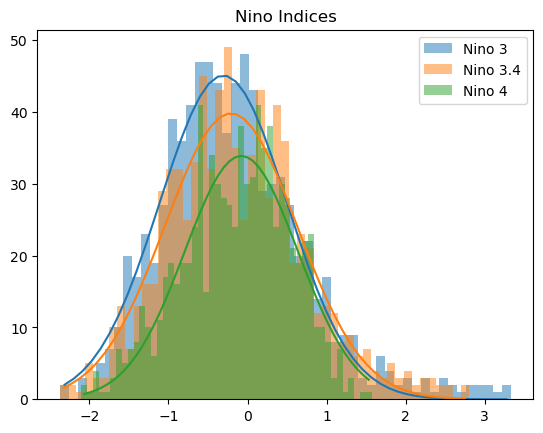

In [25]:
def gauss_func(x, A, B, C):
    return A * np.exp(-1 * B * (x - C) ** 2)


def plot_figure(x, title):
    """
    X: data to plot
    Title: title of plot
    """

    nbins = 50
    hist, bins = np.histogram(x, bins=nbins)
    centers = (
        bins[1:] + bins[:-1]
    ) / 2  # not perfect because we don't know how data is distributed in bins
    width = bins[1] - bins[0]

    # Plot Histogram
    plt.bar(centers, hist, alpha=0.5, width=width, label=title)

    # Plot Gaussian
    (a, b, c), _ = curve_fit(gauss_func, centers, hist, maxfev=5000)
    plt.plot(centers, gauss_func(centers, a, b, c))

    # Make it look pretty
    plt.legend()
    plt.title("Nino Indices")

plot_figure(x=nino3, title="Nino 3")
plot_figure(x=nino34, title="Nino 3.4")
plot_figure(x=nino4, title="Nino 4")

# Figure 2

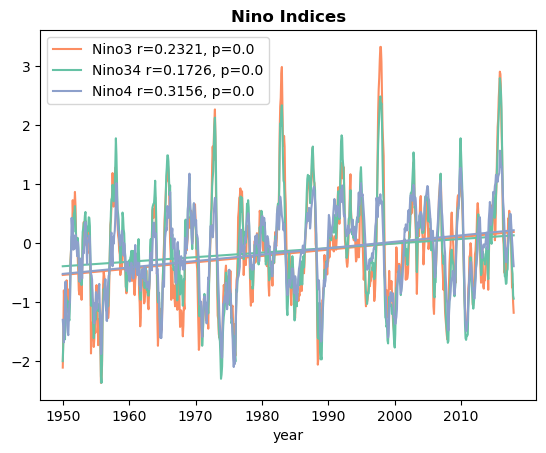

In [11]:
def plot_trend(df, label, c):
    # Raw Time Series
    plt.plot(df[0,:], color=c)

    # Linear Fit
    x = np.arange(nino34.shape[1])
    res = linregress(x, df[:])
    plt.plot(x, x * res.slope + res.intercept, label=f"{label} r={np.around(res.rvalue, 4)}, p={np.around(res.pvalue, 4)}", color=c)

    # Make it look pretty
    plt.xticks(
        ticks=np.arange(0, (2018 - 1950) * 12, 12 * 10),
        labels=np.arange(1950, 2018, 10),
    )
    plt.xlabel("year")
    plt.title(f"Nino Indices", fontweight="bold")
    plt.legend()

colors = ['#66c2a5','#fc8d62','#8da0cb']
plot_trend(nino3, label="Nino3", c=colors[1])
plot_trend(nino34, label="Nino34", c=colors[0])
plot_trend(nino4, label="Nino4", c=colors[2])

The correlation coefficient for Nino4 is larger than Nino3 and Nino34, as we may expect for a distribution with less overall variance but similar positive trends. Over the past half a century, all 3 indices show a positive trend towards more frequent El Nino conditions. These positive trends are statistically significant using a 2-tailed t-test and significance threshold of p=0.05 (our null hypothesis is that there is no trend). Given that El Nino events tend to increase global mean surface temperature, this is a worrying trend.

# Calculate Regressions

Part 1: Normalize both Nino Index and precipitation time series as $\frac{x - \mu}{\sigma}$ 

## Utility Functions

In [47]:
def normalize(df, dim="time"):
    return (df - df.mean(dim, skipna=True)) / df.std(dim, skipna=True)


def remove_mean(df, dim="time"): 
    return (df - df.mean(dim, skipna=True))
    
    
# Get correlations and pvalue from t-statistic
def get_correlations(x, y, dim="time"):
    return (xr.corr(x, y, dim=dim), xs.pearson_r_p_value(x, y, dim=dim))


# Get regression coefficient
def get_reg_coeff(x, y, dim="time"):
    return xs.linslope(x, y, dim=dim, skipna=True)


def xarray_time_to_monthly(ds):
    """
    Converts xarray from dims (time of type np.datatype64[M]) to (year, month) where year are integers and month are integers from 1 to 12

    Arguments:
    -----------
        ds [Dataset, DataArray](..., time)

    Returns:
    --------
        ds [Dataset, DataArray](..., year, month)
    """
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")


def detrend_data(data, x, x_dim, deg=1):
    """
    Detrend data using n-degree least squares fit

    Arguments:
    -----------
        data [Dataset, DataArray](..., x_dim): data to detrend (y)
        x [DataArray](x_dim): dimension to detrend along (x)
        x_dim ([tr]: name of dimension along which to detrend
        deg [int]: degree of polynomial to fit

    Returns:
    --------
        da [Dataset](..., sia, sie): detrended data
    """
    results = data.polyfit(dim=x_dim, skipna=True, deg=deg)
    new_data = data - xr.polyval(x, results.polyfit_coefficients)
    da = xr.DataArray(new_data, coords=data.coords, dims=data.dims, attrs=data.attrs)
    return da


def create_centered_levels(vmin=-.3, vmax=.5, percent_increment=.10, precision=3):
    """ 
    Note to self: add this to my ClimateUtils repo for future use and clean up 
    """
    range_values = np.abs(vmin) + np.abs(vmax)
    increment = (range_values*percent_increment / 2)
    
    upper_half = np.arange(increment, vmax, increment)
    lower_half = np.flip(np.arange(-increment, vmin-increment, -increment))
    levels = np.concatenate((lower_half, upper_half))
    
    return [np.around(level, precision) for level in levels]

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/glade/scratch/zespinosa/ipykernel_65277/3198293370.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(


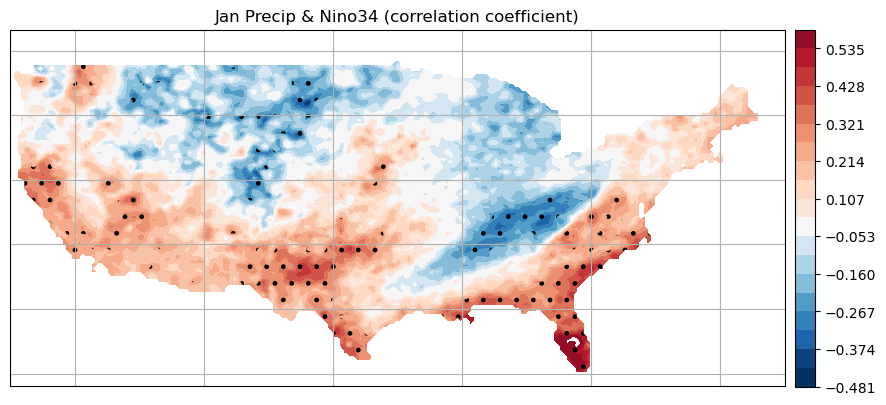

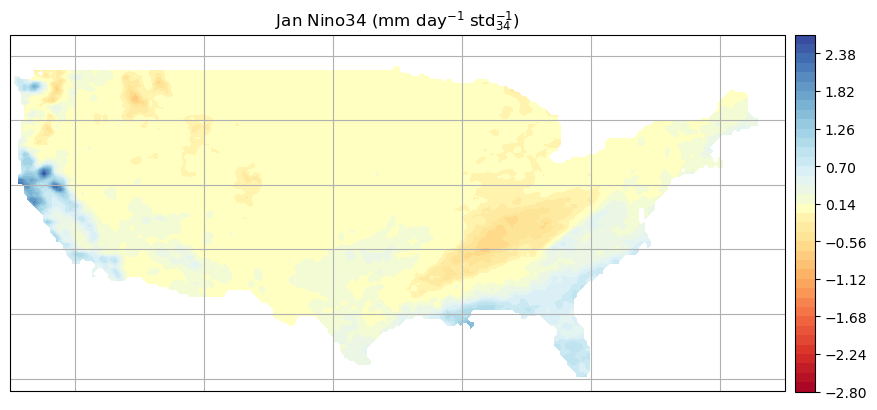

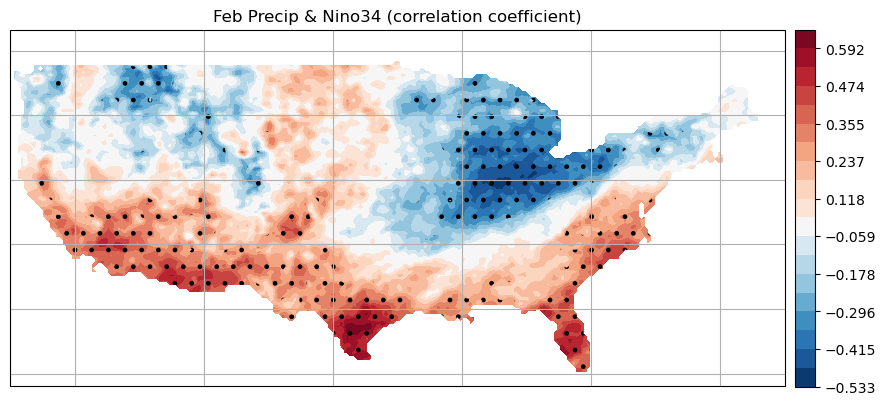

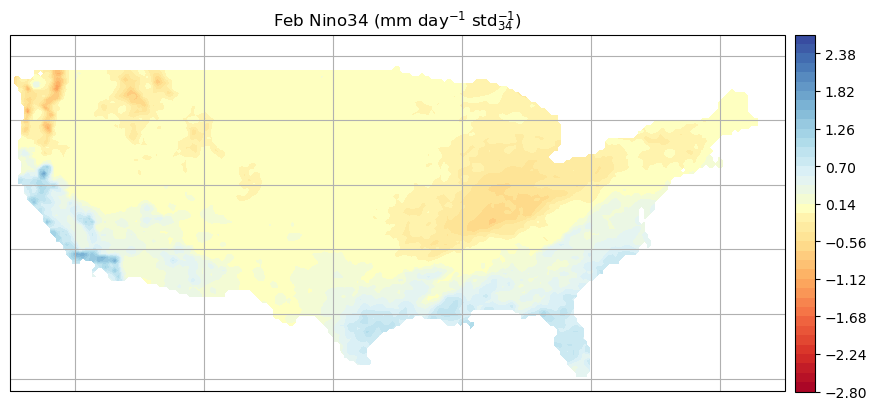

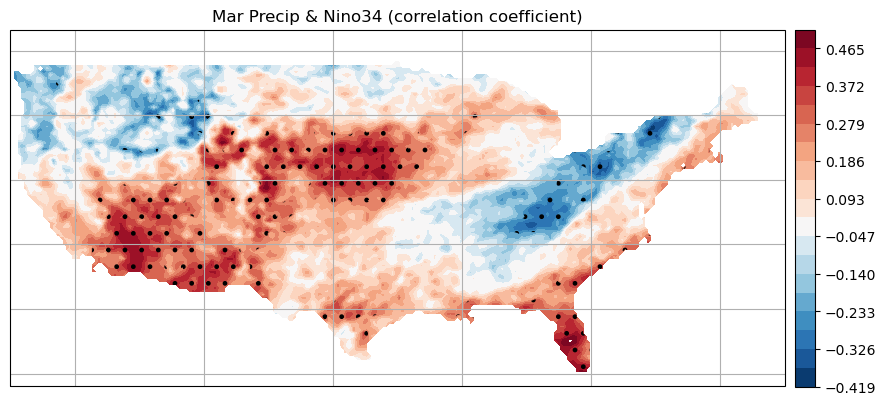

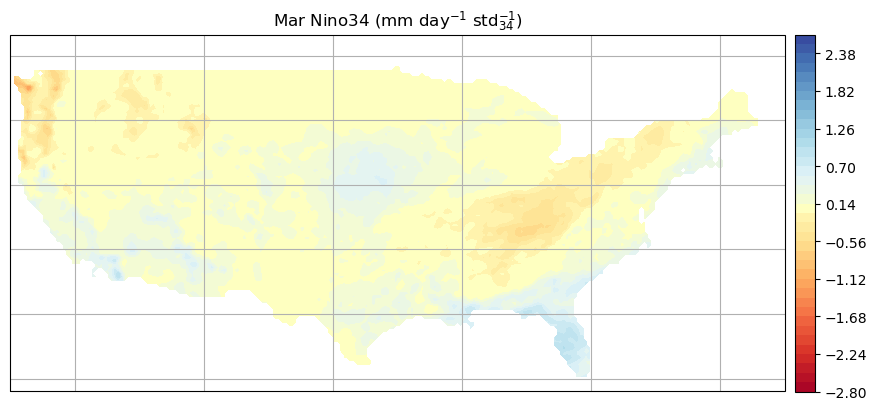

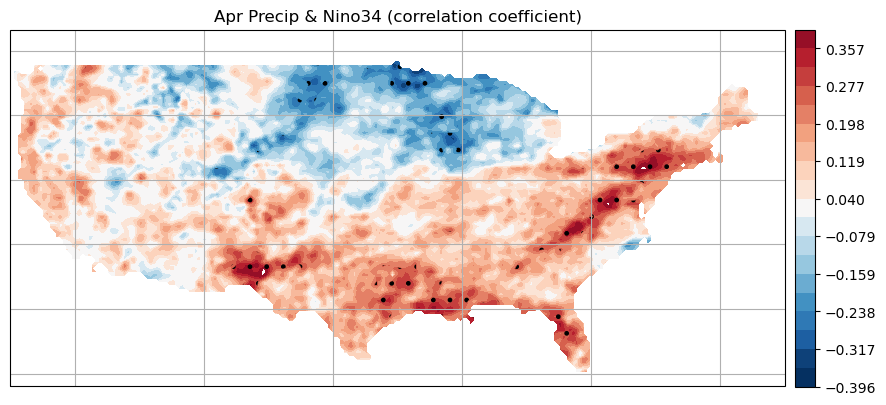

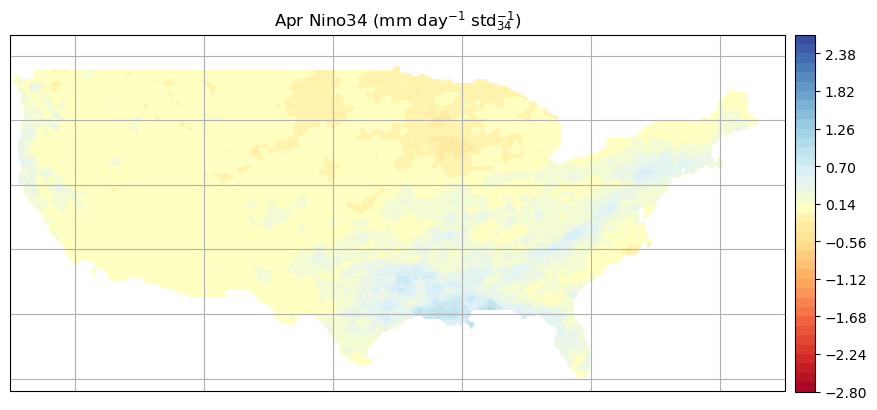

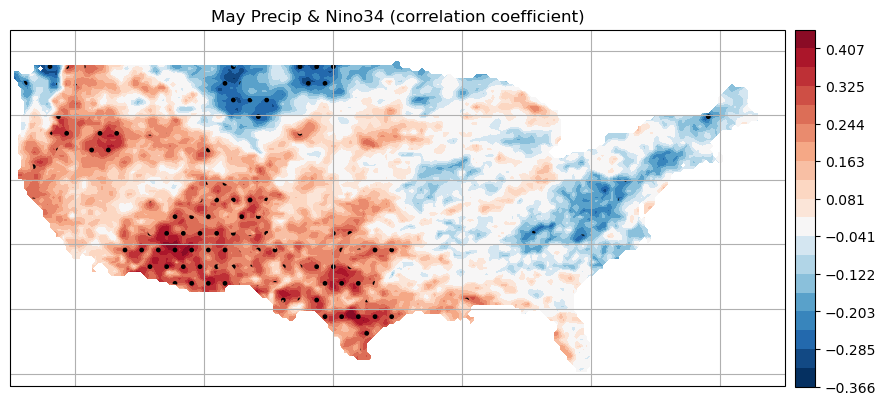

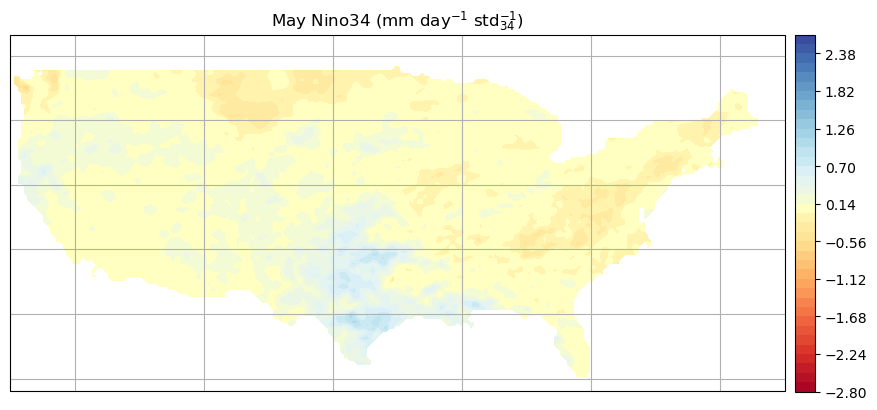

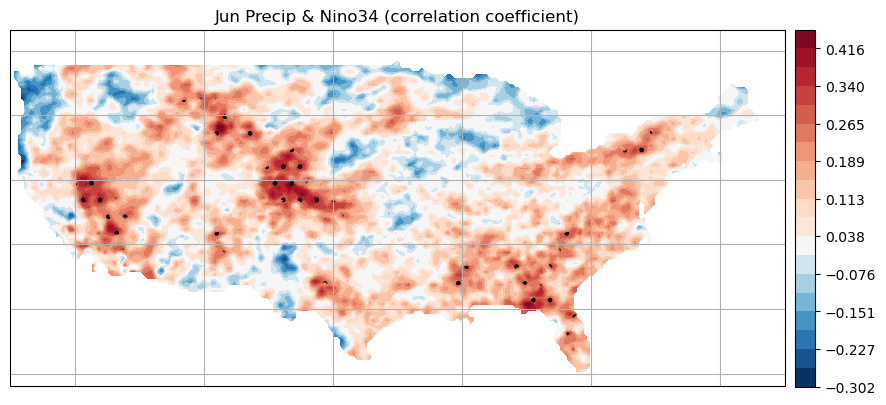

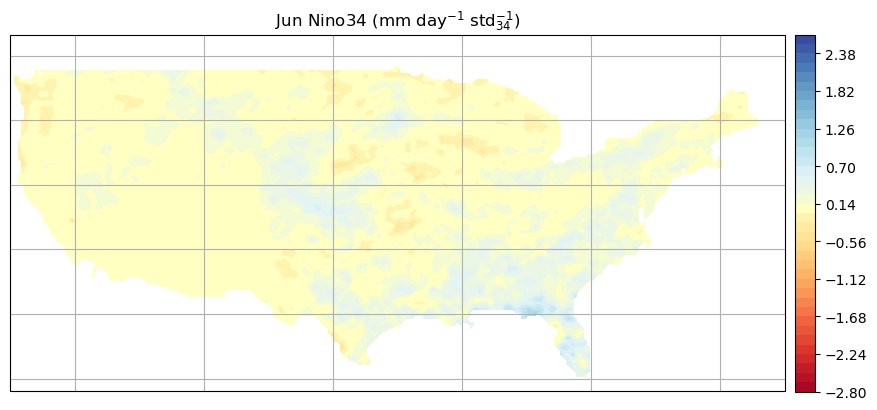

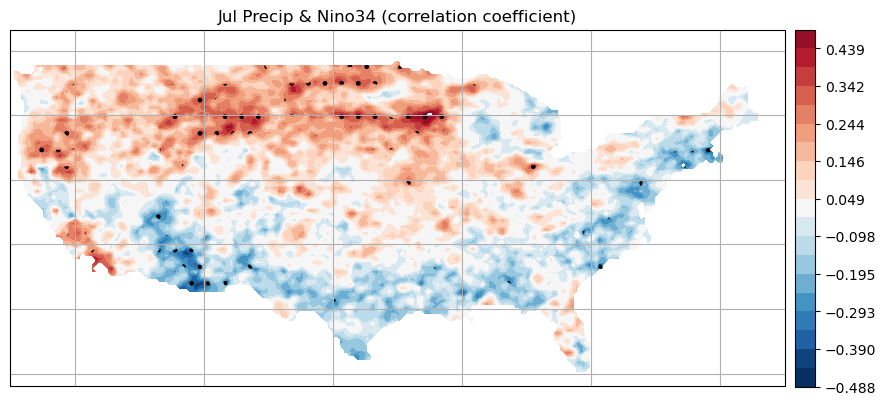

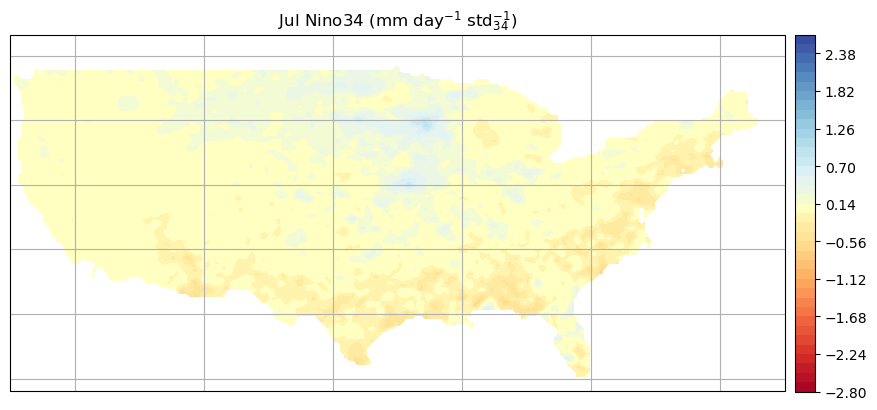

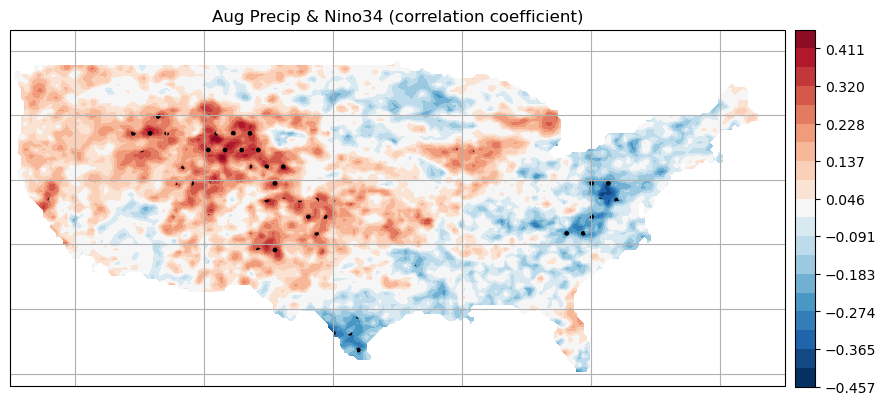

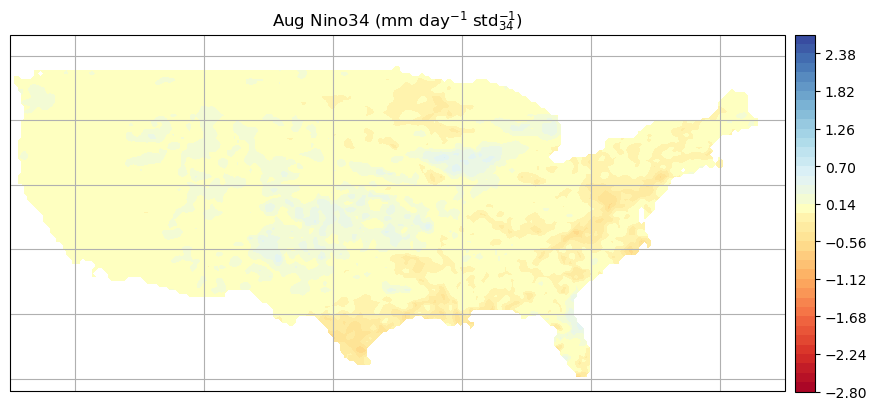

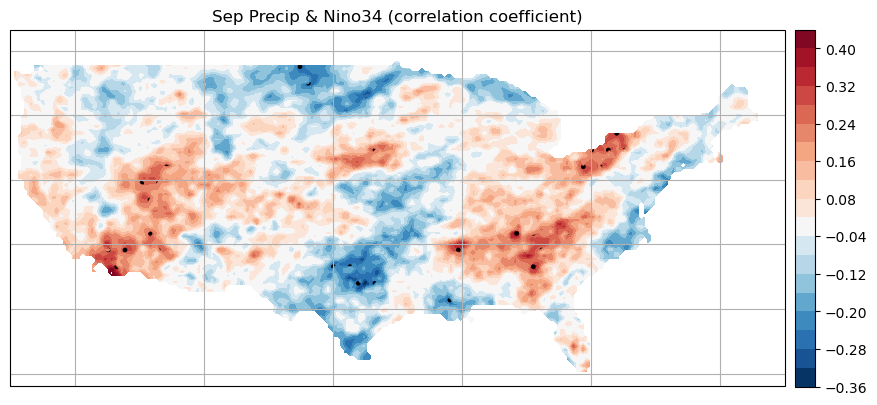

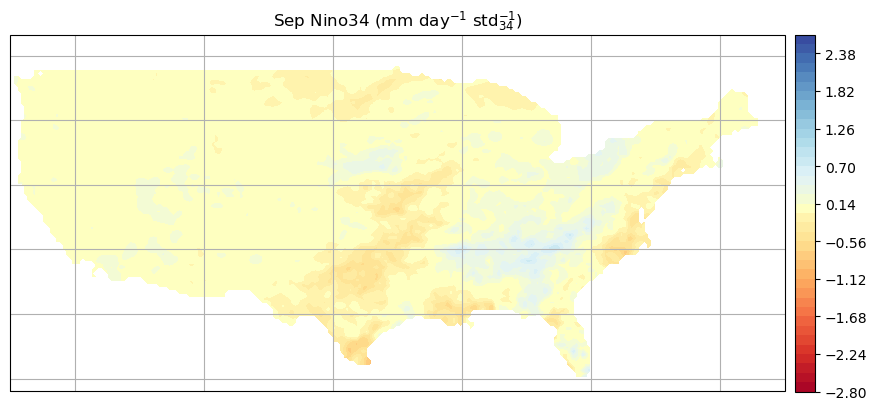

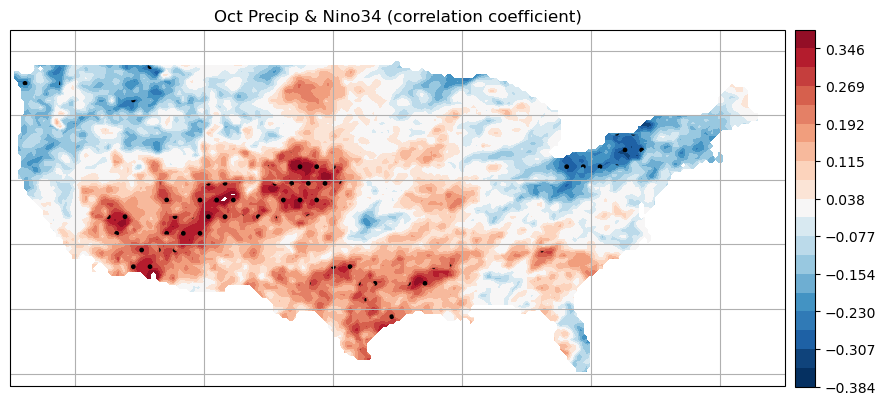

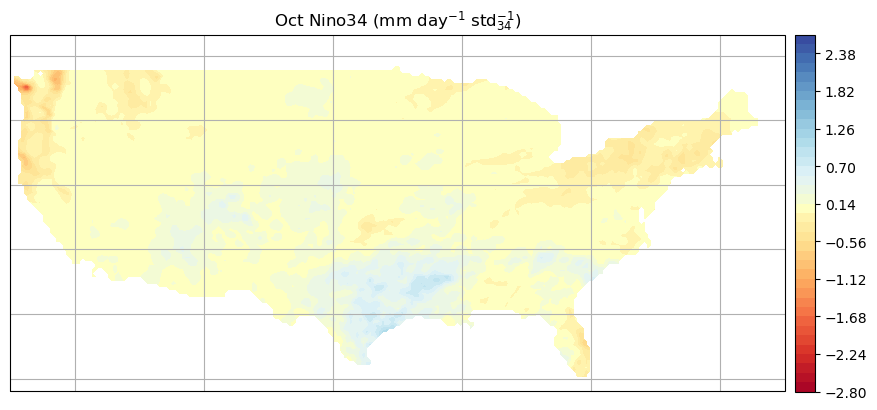

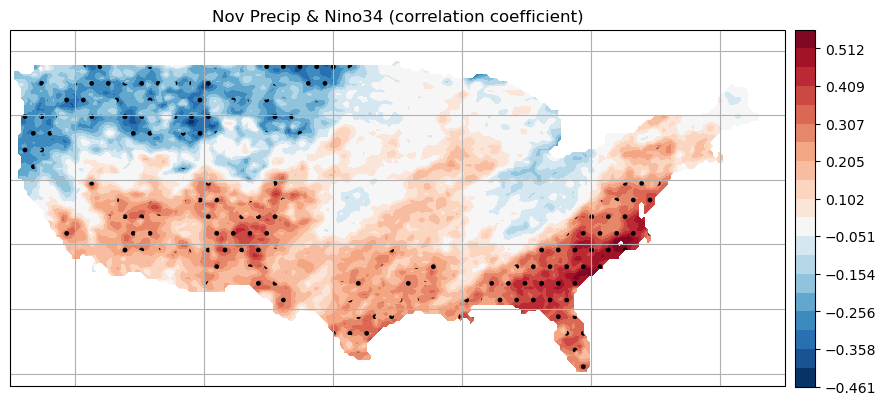

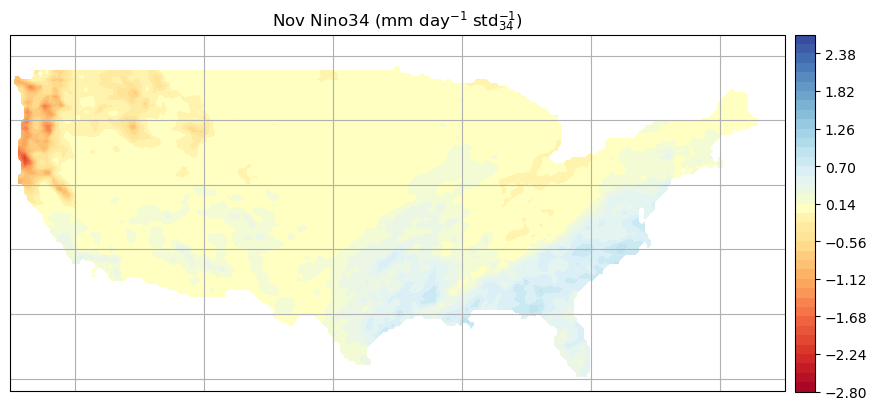

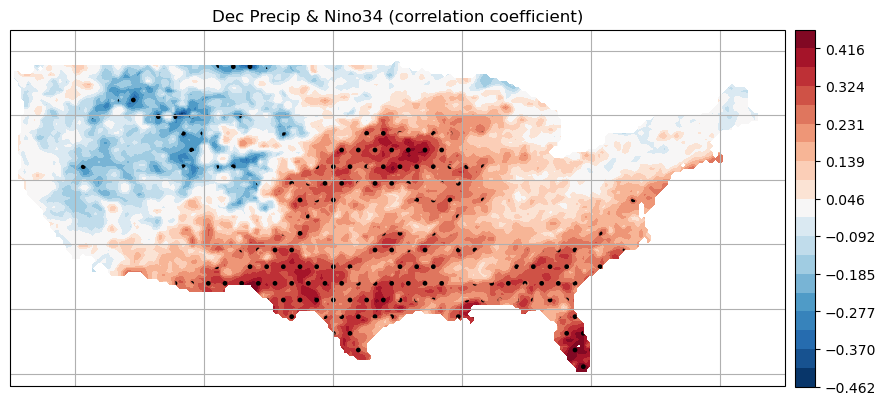

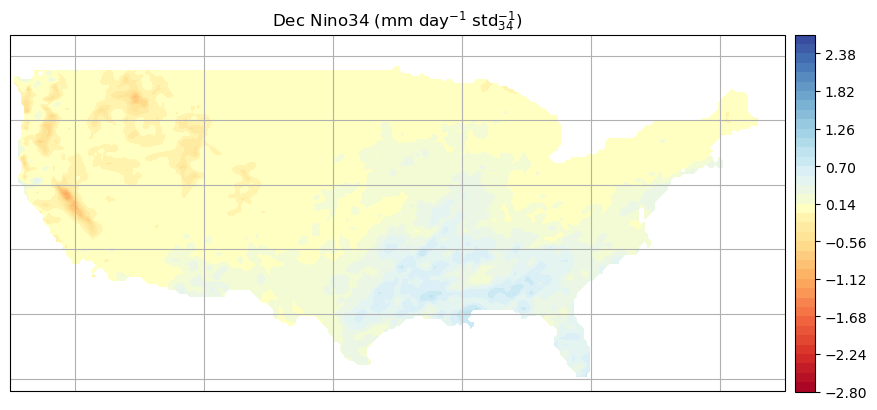

In [53]:
def calculate_correlations_and_pvalues(precip, time, nino=nino34):
    """
    This is for preprocessing data
    """
    # 1. Convert nino index numpy.darray into xarray
    nino_df = xr.DataArray(nino[0, :], coords={"time": time})

    # 2. Convert from dims (lon, lat, time) => (lon, lat, year, month)
    nino_monthly = xarray_time_to_monthly(nino_df)

    # 3. Remove the seasonal cycle and the long-term linear trend
    nino_monthly_anoms = detrend_data(nino_monthly, nino_monthly.year, "year")

    # 4. Normalize the anomalies (mean should already by zero, so really we're just standardizing)
    nino_monthly_anoms_normed = normalize(nino_monthly_anoms, dim="year")
    
    # 5. Get the correlations and pvalues
    nino_corr, nino_pvalues = get_correlations(x=precip_monthly_anoms_normed, y=nino_monthly_anoms_normed, dim="year")

    return nino_corr, nino_pvalues, nino_monthly_anoms_normed
   
    
def plot_corr_spatial_maps(lon, lat, data, sig=None, title=""):
    """
    This is for plotting correlation coefficient and statistical significance
    """
    fig, ax = plt.subplots(
        1, 1, figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    ax.gridlines()
    
    vmin, vmax = np.nanmin(data), np.nanmax(data)
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    levels = create_centered_levels(vmin, vmax)
    im = ax.contourf(lon, lat, data, cmap="RdBu_r", norm=norm, levels=levels)
    
    levels = [0, 0.05, 1]
    if np.all(sig != None):
        ax.contourf(lon, lat, sig, levels=levels, hatches=[".", ""], alpha=0)

    ax.set_extent([235, 295, 24, 48])
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    ax.set_title(title)
    plt.colorbar(im, cax=cax)
    

def plot_slopes_spatial_maps(lon, lat, data, title="Hello World", cmap="RdYlBu"):
    """
    This is for plotting the regression coefficient
    """
    fig, ax = plt.subplots(
        1, 1, figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    ax.gridlines()
    # vmin, vmax = np.nanmin(data), np.nanmax(data)
    vmin, vmax = -2.8, 2.8
    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    levels = create_centered_levels(vmin, vmax, 0.05)
    im = ax.contourf(lon, lat, data, cmap=cmap, norm=norm, levels=levels)
    
    ax.set_extent([235, 295, 24, 48])
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.01,
            ax.get_position().y0,
            0.02,
            ax.get_position().height,
        ]
    )
    ax.set_title(title)
    plt.colorbar(im, cax=cax)


# Prepare precipitation data
precip_monthly = xarray_time_to_monthly(precip.precip)
precip_monthly_anoms = detrend_data(precip_monthly, precip_monthly.year, "year")
precip_monthly_anoms_normed = normalize(precip_monthly_anoms, dim="year")

# Get spatial correlation maps
corr, pvalues, nino_monthly = calculate_correlations_and_pvalues(nino=nino34, precip=precip_monthly_anoms_normed, time=precip.precip.time.values)

# Get regression coefficients
slopes = get_reg_coeff(y=remove_mean(precip_monthly, dim="year"), x=normalize(nino_monthly, dim="year"), dim="year")

# Iterate over all months and plot
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for mon in np.arange(1, 13):
    cur_month = months[mon-1]
    corr_mon = corr.sel(month=mon)
    pvalues_mon = pvalues.sel(month=mon)
    slopes_mon = slopes.sel(month=mon)
    
    # First plot correlation map
    plot_corr_spatial_maps(
        lon=precip.lon, lat=precip.lat, data=corr_mon, sig=pvalues_mon, title=f"{cur_month} Precip & Nino34 (correlation coefficient)"
    )
    # Second plot regression coeff map
    plot_slopes_spatial_maps(lon=precip.lon, lat=precip.lat, data=slopes_mon, title=f"{cur_month} " + r"Nino34 (mm day$^{-1}$ std$_{34}^{-1}$)")

    

# Discussion


## Introduction
In this short report we use regression analysis to examine the relationship between precipitation in the continental United States and various ENSO indicies (i.e. Nino3, Nino34, Nino4). The aim of this analysis is to examine how well variations in ENSO can be used to predict precipitation variations in the United States. 

## Methods & Discussion 
For our analysis we use quarter-degree monthly precipitation data cover the continental United States from 1950-01 to 2017-12 (http://www.esrl.noaa.gov/psd/data/gridded/data.unified.html). Note that the time-series goes from 1948-01 to 2018-01, but we subset it to 1950-01 to 2017-12 for all analysis. We use long-term monthly ENSO indices, Niño3, Niño3.4 and Niño4 from 1950-01 to 2017-12 (http://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/). 

We begin our analysis by tabulating summary statistics, mean, median, standard deviation, skew, and kurtosis (Table 1) from each dataset. Summary statistics are calculated using built-in numpy and scipy.stat functionality. First off, I knew that precipitation data was generally positively skewed and heavy-tailed, but I didn't expect the kurtosis to be so high. All three of the Nino indices have similar summary statistics, with Nino3 and Nino34 being more similar to each other than Nino4. The skew becomes more negative (less positive) and the kurtosis and standard deviation decrease as we move from the Eastern Pacific to the Western Pacific. I do not necessarily know why the Eastern Pacific appears to be more variable, but my first guess is that it may be associated with the cold tongue, or easterly winds driving Eastern Pacific upwelling. 

Next, we create a histogram for each of Nino indicies (Figure 1), and find the best-fit Gaussian using scipy.stats.curve_fit. In Figure 2 examine the ENSO indicies' time-series and use scipy.stats.linregress to create a linear line-of-best-fit from 1950 to 2018. For each line we report the Pearson correlation coefficient and p-value for a hypothesis test whose null hypothesis is that the slope is zero, using a two-tailed t-distribution. We observe that over the past half century, all 3 indices show a positive trend towards more frequent El Nino conditions. These positive trends are statistically significant using a 2-tailed t-test and significance threshold of p=0.05 (our null hypothesis is that there is no trend), and the correlation coefficient for Nino4 is larger than Nino3 and Nino34, as we may expect for a distribution with less overall variance but similar positive trends. Given that El Nino events tend to increase global mean surface temperature, this is a worrying trend.

In the final set of analysis we examine spatial maps of pearson correlation coefficient between precipitation and Nino34 for each month, with stippling indicating statistical significance using a 2-tailed t-test with our significance threshold at p-value < 0.05. We also plot spatial maps of the regression coefficient for each month. First, in order to calculate the pearson correlation coefficient we begin calculating anomalies for the Nino index and precipitation by removing their seasonal cycle and the long-term lienar trend (using the utility function - detrend _data provided above). Next, for each month, we normalize the anomalies by dividing by the standard deviation (note that we do not need to subtract the mean because in anomaly space it is already 0). Finally, we calculation the correlations and pvalues using xarrays built in correlation function and xskillscore's utility function pearson_r_p_value, both of which are designed to be computationally efficient for multidimensional xarray DataArrays. In order to calculate the regression coefficient for each month we follow the same procedure, but we do not standardize the precipitation anomalies by dividing by the standard deviation. 

In January there are maximum positive correlations of around .5 in Florida and Southern Texas and negative correlations of around -.5 in the Appalachian mountains that are statistically significant (pvalue < 0.05) where the null hypothesis is that there is no relationship between precipitation and the Nino34 index. While these are significant, Nino only explains about 25% of the variance of precipitation in this region. The regression coefficient in January is most positive in the Western United states (California). In February the spatial maps like quite similar, with larger negative correlations in the midwest near the Great lakes, a larger region of positive correlation in the south-western part of the U.S.  and in March there are large regions of positive correlation in the Rocky Mountains and throughout the Nevada , Arizona, and Utah. 

June through October there are very few regions that are correlated with statistical significance, and the few locations that are significant I would be hesitant to draw conclusions from. Given that our maps are roughly 120x360 grid points, using the binomial distribution, it is very likely that some of these points have pvalues < 0.05 simply by chance. 

In November and December large regions of significant correlation reemerge. We conclude from this analysis that ENSO has the largest impact on precipitation in the United States during the late fall and winter months (NDJFM).